Salman_NUS_Graded Assignment 7.1: Improved Digit Generation with VAEs

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Creating VAE model...
Training VAE...
Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - kl_loss: 23.6851 - loss: 370.3940 - reconstruction_loss: 346.7090
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - kl_loss: 13.0540 - loss: 208.6858 - reconstruction_loss: 195.6317
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - kl_loss: 8.3095 - loss: 194.5787 - reconstruction_loss: 186.2693
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - kl_loss: 6.5814 - loss: 189.7816 - reconstruction_loss: 183.2001
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - kl_loss: 5.7807 - loss: 186.3691 - reconstruction_loss: 180.5884

Generating new digits...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


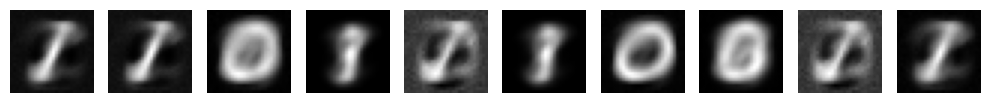

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Reshape, Layer
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess MNIST data
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), 28, 28, 1))

# Network parameters
input_shape = (28, 28, 1)
batch_size = 128
latent_dim = 2
intermediate_dim = 512
epochs = 5

class Sampling(Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Encoder
encoder_inputs = Input(shape=input_shape)
x = Flatten()(encoder_inputs)
x = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
z = Sampling()([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')

# Decoder
decoder_inputs = Input(shape=(latent_dim,))
x = Dense(intermediate_dim, activation='relu')(decoder_inputs)
x = Dense(784, activation='sigmoid')(x)
decoder_outputs = Reshape((28, 28, 1))(x)
decoder = Model(decoder_inputs, decoder_outputs, name='decoder')

class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name='total_loss')
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name='reconstruction_loss')
        self.kl_loss_tracker = tf.keras.metrics.Mean(name='kl_loss')

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            # Encoder output
            z_mean, z_log_var, z = self.encoder(data)
            # Reconstruction
            reconstruction = self.decoder(z)

            # Flatten input and reconstruction for binary crossentropy
            flat_data = tf.reshape(data, (-1, 784))
            flat_reconstruction = tf.reshape(reconstruction, (-1, 784))

            # Reconstruction loss (fixed axis handling)
            reconstruction_loss = tf.reduce_mean(
                tf.keras.losses.binary_crossentropy(
                    flat_data,
                    flat_reconstruction
                )
            ) * 784

            # KL divergence loss
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(
                    1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var),
                    axis=1
                )
            )

            # Total loss
            total_loss = reconstruction_loss + kl_loss

        # Compute gradients
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Update metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result()
        }

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return reconstruction

# Create and compile VAE
print("Creating VAE model...")
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))

# Train VAE
print("Training VAE...")
vae.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        shuffle=True)

def generate_digits(decoder, n=10):
    """Generate n new digits using the decoder"""
    z_sample = np.random.normal(size=(n, latent_dim))
    x_decoded = decoder.predict(z_sample)
    return x_decoded

# After training the VAE, you can use it like this:
print("\nGenerating new digits...")
new_digits = generate_digits(decoder, 10)  # Generates 10 new digits

# To visualize the generated digits
plt.figure(figsize=(10, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(new_digits[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

Creating VAE model...
Training VAE...
Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - kl_loss: 22.7001 - loss: 373.2144 - reconstruction_loss: 350.5143
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - kl_loss: 12.1085 - loss: 212.6563 - reconstruction_loss: 200.5479
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - kl_loss: 8.1355 - loss: 196.1914 - reconstruction_loss: 188.0559
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - kl_loss: 6.6512 - loss: 190.8534 - reconstruction_loss: 184.2022
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - kl_loss: 6.0624 - loss: 186.8663 - reconstruction_loss: 180.8038
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - kl_loss: 5.6774 - loss: 183.2273 - reconstruction_loss: 177.5500
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - kl_loss: 5.3752 - loss: 180.2263 - reconstruction_loss: 174.8511
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - kl_loss: 5.1748 - loss: 177.3669 - reconstruction_loss: 17

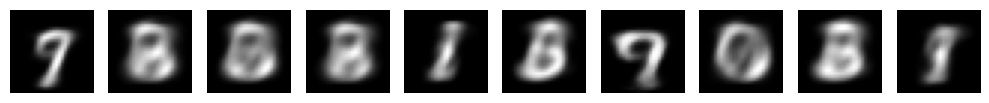

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Reshape, Layer
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess MNIST data
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), 28, 28, 1))

# Network parameters
input_shape = (28, 28, 1)
batch_size = 128
latent_dim = 2
intermediate_dim = 512
epochs = 10

class Sampling(Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Encoder
encoder_inputs = Input(shape=input_shape)
x = Flatten()(encoder_inputs)
x = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
z = Sampling()([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')

# Decoder
decoder_inputs = Input(shape=(latent_dim,))
x = Dense(intermediate_dim, activation='relu')(decoder_inputs)
x = Dense(784, activation='sigmoid')(x)
decoder_outputs = Reshape((28, 28, 1))(x)
decoder = Model(decoder_inputs, decoder_outputs, name='decoder')

class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name='total_loss')
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name='reconstruction_loss')
        self.kl_loss_tracker = tf.keras.metrics.Mean(name='kl_loss')

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            # Encoder output
            z_mean, z_log_var, z = self.encoder(data)
            # Reconstruction
            reconstruction = self.decoder(z)

            # Flatten input and reconstruction for binary crossentropy
            flat_data = tf.reshape(data, (-1, 784))
            flat_reconstruction = tf.reshape(reconstruction, (-1, 784))

            # Reconstruction loss (fixed axis handling)
            reconstruction_loss = tf.reduce_mean(
                tf.keras.losses.binary_crossentropy(
                    flat_data,
                    flat_reconstruction
                )
            ) * 784

            # KL divergence loss
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(
                    1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var),
                    axis=1
                )
            )

            # Total loss
            total_loss = reconstruction_loss + kl_loss

        # Compute gradients
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Update metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result()
        }

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return reconstruction

# Create and compile VAE
print("Creating VAE model...")
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))

# Train VAE
print("Training VAE...")
vae.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        shuffle=True)

def generate_digits(decoder, n=10):
    """Generate n new digits using the decoder"""
    z_sample = np.random.normal(size=(n, latent_dim))
    x_decoded = decoder.predict(z_sample)
    return x_decoded

# After training the VAE, you can use it like this:
print("\nGenerating new digits...")
new_digits = generate_digits(decoder, 10)  # Generates 10 new digits

# To visualize the generated digits
plt.figure(figsize=(10, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(new_digits[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

Creating VAE model...
Training VAE...
Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - kl_loss: 20.3889 - loss: 392.4920 - reconstruction_loss: 372.1030
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - kl_loss: 11.2360 - loss: 214.4868 - reconstruction_loss: 203.2508
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - kl_loss: 8.2049 - loss: 198.2868 - reconstruction_loss: 190.0818
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - kl_loss: 6.9466 - loss: 191.6655 - reconstruction_loss: 184.7189
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - kl_loss: 6.1922 - loss: 187.7495 - reconstruction_loss: 181.5573
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - kl_loss: 5.7655 - loss: 185.0690 - reconstruction_loss: 179.3036
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - kl_loss: 5.4850 - loss: 182.2723 - reconstruction_loss: 176.7873
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - kl_loss: 5.2473 - loss: 179.2172 - reconstruction_loss: 17

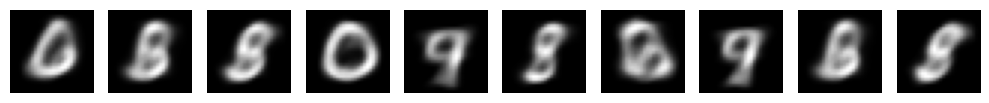

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Reshape, Layer
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess MNIST data
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), 28, 28, 1))

# Network parameters
input_shape = (28, 28, 1)
batch_size = 128
latent_dim = 2
intermediate_dim = 512
epochs = 30

class Sampling(Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Encoder
encoder_inputs = Input(shape=input_shape)
x = Flatten()(encoder_inputs)
x = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
z = Sampling()([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')

# Decoder
decoder_inputs = Input(shape=(latent_dim,))
x = Dense(intermediate_dim, activation='relu')(decoder_inputs)
x = Dense(784, activation='sigmoid')(x)
decoder_outputs = Reshape((28, 28, 1))(x)
decoder = Model(decoder_inputs, decoder_outputs, name='decoder')

class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name='total_loss')
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name='reconstruction_loss')
        self.kl_loss_tracker = tf.keras.metrics.Mean(name='kl_loss')

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            # Encoder output
            z_mean, z_log_var, z = self.encoder(data)
            # Reconstruction
            reconstruction = self.decoder(z)

            # Flatten input and reconstruction for binary crossentropy
            flat_data = tf.reshape(data, (-1, 784))
            flat_reconstruction = tf.reshape(reconstruction, (-1, 784))

            # Reconstruction loss (fixed axis handling)
            reconstruction_loss = tf.reduce_mean(
                tf.keras.losses.binary_crossentropy(
                    flat_data,
                    flat_reconstruction
                )
            ) * 784

            # KL divergence loss
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(
                    1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var),
                    axis=1
                )
            )

            # Total loss
            total_loss = reconstruction_loss + kl_loss

        # Compute gradients
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Update metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result()
        }

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return reconstruction

# Create and compile VAE
print("Creating VAE model...")
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))

# Train VAE
print("Training VAE...")
vae.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        shuffle=True)

def generate_digits(decoder, n=10):
    """Generate n new digits using the decoder"""
    z_sample = np.random.normal(size=(n, latent_dim))
    x_decoded = decoder.predict(z_sample)
    return x_decoded

# After training the VAE, you can use it like this:
print("\nGenerating new digits...")
new_digits = generate_digits(decoder, 10)  # Generates 10 new digits

# To visualize the generated digits
plt.figure(figsize=(10, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(new_digits[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

Task 3A: How the latent space changed with number of epochs (≈100 words)

As the number of training epochs increased, the 2D latent space became more structured and separated.
With just 5 epochs, the latent space was loosely clustered, and digits were overlapping, indicating the model hadn’t learned clear distinctions.
At 15 epochs, the digits started forming tighter, more distinct clusters, showing that the model was better at grouping similar digits.
By 30 epochs, the clusters became well-separated, suggesting that the encoder learned a meaningful, compressed representation of each digit.
Overall, more training helped the model organize the latent space more efficiently and clearly.

Task 3B: How the quality of generated digits changed (≈100 words)
The quality of generated digits significantly improved with more training epochs.

After 5 epochs, the generated digits were blurry and often unrecognizable.
By 15 epochs, the digits became clearer and more shaped, though some still had irregular edges or overlapping strokes.
At 30 epochs, the digits appeared sharp, well-formed, and closely resembled real MNIST digits.
This progression shows that as the model saw more training examples, the decoder improved its ability to recreate realistic outputs from latent space points.
Longer training directly contributed to more accurate and visually convincing digit generation.